In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi
import time
import matplotlib.pyplot as plt

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
good_event = [689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785, 37, 24, 75, 72, 35, 16, 12, 1718, 1, 9]
print(len(good_event))

38


**Monte Carlo**

Monte Carlo event 689 with noise: 1.8157727718353271 seconds
position chi2: 94.97058186115162 energy chi2: 6.708007507720643 vertex chi^2: 0.02955432103439242 total chi2: 101.70814368990665
Monte Carlo event 689 without noise: 0.4516446590423584 seconds
position chi2: 21.977395599361646 energy chi2: 8.169946038161633 vertex chi^2: 3.4886581910491414 total chi2: 33.63599982857242
Monte Carlo event 765 with noise: 0.7418649196624756 seconds
position chi2: 88.76454955315639 energy chi2: 11.087112495497363 vertex chi^2: 0.14608832518597636 total chi2: 99.99775037383972
Monte Carlo event 765 without noise: 0.44197773933410645 seconds
position chi2: 11.682155895194041 energy chi2: 14.164682836761328 vertex chi^2: 7.411791371404442 total chi2: 33.25863010335981
Monte Carlo event 896 with noise: 1.0901288986206055 seconds
position chi2: 96.18607127989591 energy chi2: 3.407991216369844 vertex chi^2: 0.22968175079659067 total chi2: 99.82374424706235
Monte Carlo event 896 without noise: 0.7823107

Monte Carlo event 745 without noise: 1.5662095546722412 seconds
position chi2: 34.908526491013596 energy chi2: 1.9571017916075293 vertex chi^2: 0.13483792424095314 total chi2: 37.00046620686208
Monte Carlo event 430 with noise: 1.8785247802734375 seconds
position chi2: 93.61530840949492 energy chi2: 5.195246774656546 vertex chi^2: 0.15027740198096914 total chi2: 98.96083258613244
Monte Carlo event 430 without noise: 0.6548655033111572 seconds
position chi2: 23.081936524623874 energy chi2: 6.2816536602458175 vertex chi^2: 7.28064168011017 total chi2: 36.644231864979865
Monte Carlo event 1676 with noise: 2.155144691467285 seconds
position chi2: 90.4503654620487 energy chi2: 4.603863212244063 vertex chi^2: 0.3415828765996111 total chi2: 95.39581155089238
Monte Carlo event 1676 without noise: 0.8655307292938232 seconds
position chi2: 23.136198583188587 energy chi2: 5.016372098845285 vertex chi^2: 3.4875637779333695 total chi2: 31.640134459967243
Monte Carlo event 811 with noise: 1.00264286

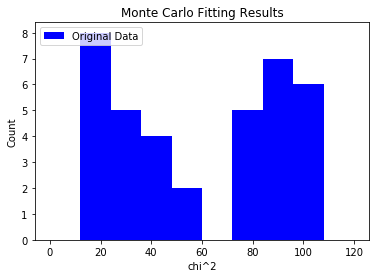

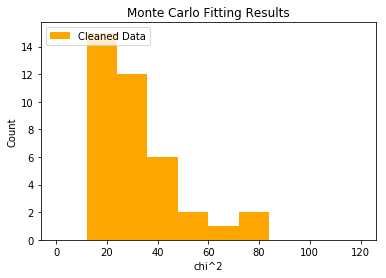

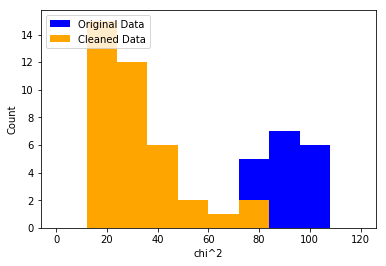

In [4]:
mc_chi2_with_noise = []
mc_chi2_without_noise = []
time_list_with_noise = []
time_list_without_noise = []

for i in range(len(good_event)):
    evt_ID = good_event[i]
    dataset_name = '/clean'
    evt_full = full[dataset_name]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 150.0:
            del_list.append(i)
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    
    xy = xyzs[:, 0:2]
    xy_C = np.ascontiguousarray(xy, dtype=np.double)
    cx, cy = pytpc.cleaning.hough_circle(xy_C)

    cut_xy = cut_xyzs[:, 0:2]
    cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
    cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
    
    t0 = time.time()
    uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False) # get calibrated set of data
    uvw_values = uvw.values #transform pd file to arrays
    mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)
    t1 = time.time()
    if np.isnan(mcres['posChi2']) != True:
        mc_chi2_with_noise.append(mcres['posChi2']+mcres['enChi2']+mcres['vertChi2'])
    time_list_with_noise.append(t1-t0)
    print("Monte Carlo event "+str(evt_ID)+" with noise: "+str(t1-t0)+' seconds')
    print("position chi2: "+str(mcres['posChi2'])+' energy chi2: '+str(mcres['enChi2'])+' vertex chi^2: '+str(mcres['vertChi2'])+' total chi2: '+str(mcres['posChi2']+mcres['enChi2']+mcres['vertChi2']))
    
    t2 = time.time()
    cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
    cut_uvw_values = cut_uvw.values #transform pd file to arrays
    cut_mcres, cut_minChis, cut_all_params, cut_good_param_idx = mcfitter.process_event(cut_uvw, cut_cu, cut_cv, return_details=True)
    t3 = time.time()
    if np.isnan(cut_mcres['posChi2']) != True:
        mc_chi2_without_noise.append(cut_mcres['posChi2']+cut_mcres['enChi2']+cut_mcres['vertChi2'])
    time_list_without_noise.append(t3-t2)
    print("Monte Carlo event "+str(evt_ID)+" without noise: "+str(t3-t2)+' seconds')
    print("position chi2: "+str(cut_mcres['posChi2'])+' energy chi2: '+str(cut_mcres['enChi2'])+' vertex chi^2: '+str(cut_mcres['vertChi2'])+' total chi2: '+str(cut_mcres['posChi2']+cut_mcres['enChi2']+cut_mcres['vertChi2']))
    
#print(chi2_with_noise)
#print(chi2_without_noise)
print("average time with noise: "+str(sum(time_list_with_noise) / float(len(time_list_with_noise)))+" seconds")
print("average time without noise: "+str(sum(time_list_without_noise) / float(len(time_list_without_noise)))+" seconds")
print('average chi2 value (with noise): '+ str(sum(mc_chi2_with_noise) / float(len(mc_chi2_with_noise))))
print('average chi2 value (without noise): '+ str(sum(mc_chi2_without_noise) / float(len(mc_chi2_without_noise))))

plt.hist(mc_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.title('Monte Carlo Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(mc_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.title('Monte Carlo Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(mc_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.hist(mc_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.legend(loc=2)
plt.show()

**Differential Evolution**

In [9]:
de_chi2_with_noise = []
de_chi2_without_noise = []
time_list_with_noise = []
time_list_without_noise = []

for i in range(len(good_event)):
    evt_ID = good_event[i]
    dataset_name = '/clean'
    evt_full = full[dataset_name]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 150.0:
            del_list.append(i)
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    
    xy = xyzs[:, 0:2]
    xy_C = np.ascontiguousarray(xy, dtype=np.double)
    cx, cy = pytpc.cleaning.hough_circle(xy_C)

    cut_xy = cut_xyzs[:, 0:2]
    cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
    cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
    
    uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
    uvw_values = uvw.values
    uvw_sorted = uvw.sort_values(by='w', ascending=True)
    prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
    prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
    ctr0 = mcfitter.guess_parameters(prefit_res)
    exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    exp_hits = np.zeros(10240)
    for a, p in uvw[['a', 'pad']].values:
        exp_hits[int(p)] = a
        
    cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
    cut_uvw_values = cut_uvw.values
    cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
    cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
    cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
    cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
    cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    cut_exp_hits = np.zeros(10240)
    for a, p in cut_uvw[['a', 'pad']].values:
        cut_exp_hits[int(p)] = a
        
    minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
    
    def f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def jacobian(x):
        return scipy.optimize.approx_fprime(x,f,eps)
    
    def cut_f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def cut_jacobian(x):
        return scipy.optimize.approx_fprime(x,cut_f,eps)
    
    i = 1
    def callbackF(x, convergence=10):
        global i
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
        i += 1
        
    j = 1
    def cut_callbackF(x, convergence=10):
        global j
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
        j += 1
    
    bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
    
    t0 = time.time()
    results = scipy.optimize.differential_evolution(f, bounds, maxiter=1000, strategy='best1bin', recombination=0.7, popsize=15, mutation=(0.5,1.5))
    t1 = time.time()
    if np.isnan(results.fun) != True:
        de_chi2_with_noise.append(results.fun)
    time_list_with_noise.append(t1-t0)
    print("Differential Evolution event "+str(evt_ID)+" with noise: "+str(t1-t0)+' seconds')
    print("chi2 value: "+str(results.fun))
    
    t2 = time.time()
    cut_results = scipy.optimize.differential_evolution(cut_f, bounds, maxiter=1000, strategy='best1bin',recombination=0.7, popsize=15, mutation=(0.5,1.5))
    t3 = time.time()
    if np.isnan(cut_results.fun) != True:
        de_chi2_without_noise.append(cut_results.fun)
    time_list_without_noise.append(t3-t2)
    print("Differential Evolution event "+str(evt_ID)+" without noise: "+str(t3-t2)+' seconds')
    print("chi2 value: "+str(cut_results.fun))
    
print("average time with noise: "+str(sum(time_list_with_noise) / float(len(time_list_with_noise)))+" seconds")
print("average time without noise: "+str(sum(time_list_without_noise) / float(len(time_list_without_noise)))+" seconds")
print('average chi2 value (with noise): '+ str(sum(de_chi2_with_noise) / float(len(de_chi2_with_noise))))
print('average chi2 value (without noise): '+ str(sum(de_chi2_without_noise) / float(len(de_chi2_without_noise))))



Differential Evolution event 689 with noise: 48.333991050720215 seconds
chi2 value: 37.64730482038467
Differential Evolution event 689 without noise: 49.604042530059814 seconds
chi2 value: 49.139617014737404
Differential Evolution event 765 with noise: 47.02761387825012 seconds
chi2 value: 35.210870872798594
Differential Evolution event 765 without noise: 42.04009008407593 seconds
chi2 value: 32.92591321659861
Differential Evolution event 896 with noise: 24.90686321258545 seconds
chi2 value: 15.593719909964893
Differential Evolution event 896 without noise: 43.97443675994873 seconds
chi2 value: 29.875650652972546
Differential Evolution event 305 with noise: 45.060553789138794 seconds
chi2 value: 14.194987932669072
Differential Evolution event 305 without noise: 50.30601119995117 seconds
chi2 value: 14.172776756596797
Differential Evolution event 504 with noise: 69.87180662155151 seconds
chi2 value: 68.19324664104083
Differential Evolution event 504 without noise: 36.56284999847412 seco

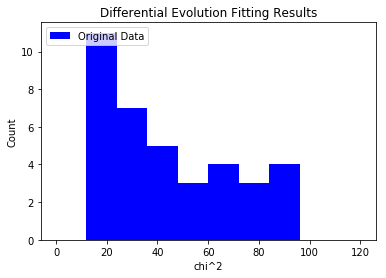

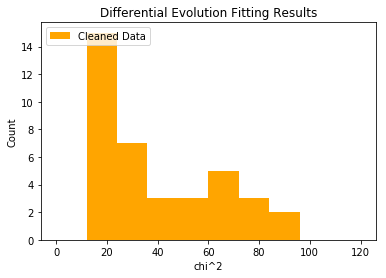

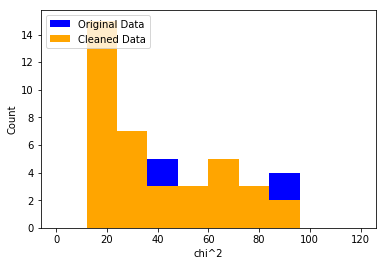

In [10]:
plt.hist(de_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.title('Differential Evolution Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(de_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.title('Differential Evolution Fitting Results')
plt.legend(loc=2)
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.show()

plt.hist(de_chi2_with_noise, label='Original Data', bins=10, color='blue',range=(0,120))
plt.hist(de_chi2_without_noise, label='Cleaned Data', bins=10, color='orange',range=(0,120))
plt.xlabel('chi^2')
plt.ylabel('Count')
plt.legend(loc=2)
plt.show()

**Basinhopping**

Basinhopping (with noise) event 689 with SLSQP method: 2.9292163848876953 seconds
chi2 value: 99.54454039260898
Basinhopping (without noise) event 689 with SLSQP method: 3.733522653579712 seconds
chi2 value: 35.919325943568566
Basinhopping (with noise) event 765 with SLSQP method: 3.4379775524139404 seconds
chi2 value: 92.94119528918141
Basinhopping (without noise) event 765 with SLSQP method: 1.966449499130249 seconds
chi2 value: 37.25644334454114
Basinhopping (with noise) event 896 with SLSQP method: 2.52176570892334 seconds
chi2 value: 91.89778218802586
Basinhopping (without noise) event 896 with SLSQP method: 3.610275983810425 seconds
chi2 value: 14.541836494296392
Basinhopping (with noise) event 305 with SLSQP method: 7.571278810501099 seconds
chi2 value: 15.013297386455186
Basinhopping (without noise) event 305 with SLSQP method: 8.486327171325684 seconds
chi2 value: 15.280251282164969
Basinhopping (with noise) event 504 with SLSQP method: 2.985952854156494 seconds
chi2 value: 84

Basinhopping (without noise) event 1 with SLSQP method: 3.7495827674865723 seconds
chi2 value: 30.208370435161868
Basinhopping (with noise) event 9 with SLSQP method: 3.413069486618042 seconds
chi2 value: 36.50090209969003
Basinhopping (without noise) event 9 with SLSQP method: 3.0630035400390625 seconds
chi2 value: 34.569108692305065
average time with noise for SLSQP: 9.127150297164917 seconds
average time without noise for SLSQP: 4.680713716306184 seconds
chi2 value (with noise) for SLSQP: 54.86550566737716
chi2 value (without noise) for SLSQP: 34.35290956493488


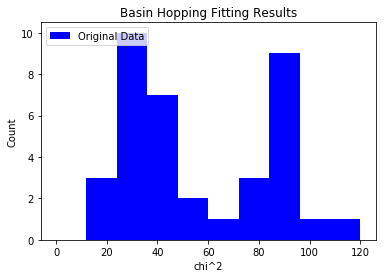

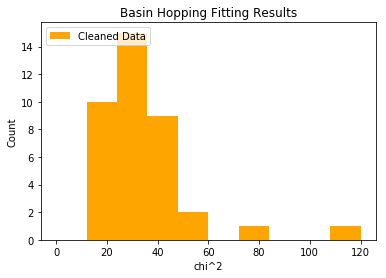

In [8]:
#chi2_with_noise = {'Nelder-Mead':[],'Powell':[],'CG':[],'BFGS':[],'L-BFGS-B':[],'TNC':[],'COBYLA':[],'SLSQP':[]}
#chi2_without_noise = {'Nelder-Mead':[],'Powell':[],'CG':[],'BFGS':[],'L-BFGS-B':[],'TNC':[],'COBYLA':[],'SLSQP':[]}
#time_list = {'Nelder-Mead':[],'Powell':[],'CG':[],'BFGS':[],'L-BFGS-B':[],'TNC':[],'COBYLA':[],'SLSQP':[]}
#methods = ['Nelder-Mead','Powell','CG','BFGS', 'L-BFGS-B','TNC','COBYLA','SLSQP']

chi2_with_noise = {'SLSQP':[]}
chi2_without_noise = {'SLSQP':[]}
time_list = {'SLSQP':[]}
methods = ['SLSQP']
time_list_with_noise = {'SLSQP':[]}
time_list_without_noise = {'SLSQP':[]}

for i in range(len(good_event)):
    evt_ID = good_event[i]
    dataset_name = '/clean'
    evt_full = full[dataset_name]
    xyzs_h5 = evt_full[str(evt_ID)]

    xyzs = np.array(xyzs_h5)

    #delete the points which are farther away from the center of the spiral
    del_list = []

    for i in range(len(xyzs)):
        if (xyzs[i,6]) > 150.0:
            del_list.append(i)
    cut_xyzs = np.delete(xyzs,del_list,axis=0)
    
    xy = xyzs[:, 0:2]
    xy_C = np.ascontiguousarray(xy, dtype=np.double)
    cx, cy = pytpc.cleaning.hough_circle(xy_C)

    cut_xy = cut_xyzs[:, 0:2]
    cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
    cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)
    
    uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
    uvw_values = uvw.values
    uvw_sorted = uvw.sort_values(by='w', ascending=True)
    prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
    prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
    ctr0 = mcfitter.guess_parameters(prefit_res)
    exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    exp_hits = np.zeros(10240)
    for a, p in uvw[['a', 'pad']].values:
        exp_hits[int(p)] = a
        
    cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
    cut_uvw_values = cut_uvw.values
    cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
    cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
    cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
    cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
    cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
    cut_exp_hits = np.zeros(10240)
    for a, p in cut_uvw[['a', 'pad']].values:
        cut_exp_hits[int(p)] = a
        
    minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
    
    def f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def jacobian(x):
        return scipy.optimize.approx_fprime(x,f,eps)
    
    def cut_f(y):
        ctr = np.zeros([1,6])
        ctr[0] = y
        chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
        return sum(chi_result[0])
    eps = np.sqrt(np.finfo(np.float).eps)
    def cut_jacobian(x):
        return scipy.optimize.approx_fprime(x,cut_f,eps)
    
    i = 1
    def callbackF(x, f, accept):
        global i
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
        i += 1
        
    j = 1
    def cut_callbackF(x, f, accept):
        global j
        print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],f))
        j += 1
        
    for a in range(len(methods)):
        method = methods[a]
        t0 = time.time()
        results = scipy.optimize.basinhopping(f,ctr0, niter=25, T=0.01, stepsize=0.05, minimizer_kwargs={"method": method})
        t1 = time.time()
        time_list_with_noise[method].append(t1-t0)
        if np.isnan(results.fun) != True:
            chi2_with_noise[method].append(results.fun)
        print('Basinhopping (with noise) event '+str(evt_ID)+' with '+str(method)+' method: '+str(t1-t0)+' seconds')
        print('chi2 value: '+str(results.fun))
        t3 = time.time()
        cut_results = scipy.optimize.basinhopping(cut_f,cut_ctr0, niter=25, T=0.01, stepsize=0.05, minimizer_kwargs={"method": method})
        t4 = time.time()
        time_list_without_noise[method].append(t4-t3)
        if np.isnan(cut_results.fun) != True:
            chi2_without_noise[method].append(cut_results.fun)
        print('Basinhopping (without noise) event '+str(evt_ID)+' with '+str(method)+' method: '+str(t4-t3)+' seconds')
        print('chi2 value: '+str(cut_results.fun))
    
for a in range(len(methods)):
    method = methods[a]
    print("average time with noise for "+method+": "+str(sum(time_list_with_noise[method]) / float(len(time_list_with_noise[method])))+" seconds")
    print("average time without noise for "+method+": "+str(sum(time_list_without_noise[method]) / float(len(time_list_without_noise[method])))+" seconds")
    print('chi2 value (with noise) for '+method+": "+str(sum(chi2_with_noise[method]) / float(len(chi2_with_noise[method]))))
    print('chi2 value (without noise) for '+method+": "+str(sum(chi2_without_noise[method]) / float(len(chi2_without_noise[method]))))
              
for i in chi2_with_noise:
    plt.hist(chi2_with_noise[i], label="Original Data", color='blue', bins=10,range=(0,120))
    plt.title('Basin Hopping Fitting Results')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('Count')
plt.show()


for i in chi2_without_noise:
    plt.hist(chi2_without_noise[i], label="Cleaned Data", color='orange', bins=10,range=(0,120))
    plt.title('Basin Hopping Fitting Results')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('Count')
plt.show()


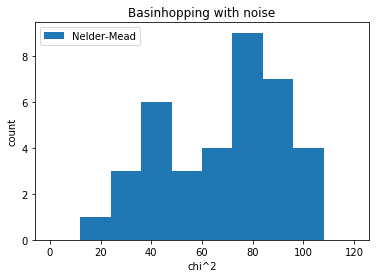

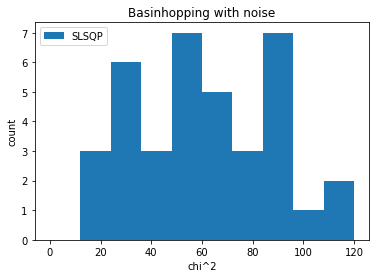

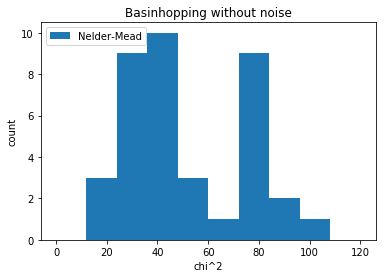

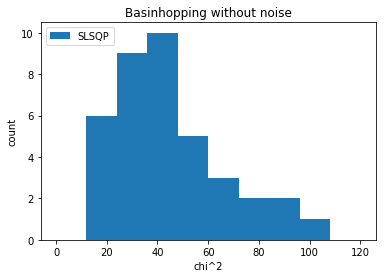

In [9]:
for i in chi2_with_noise:
    plt.hist(chi2_with_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basin Hopping - Original Data')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
    plt.show()


for i in chi2_without_noise:
    plt.hist(chi2_without_noise[i], label=i, bins=10,range=(0,120))
    plt.title('Basin Hopping - Cleaned Data')
    plt.legend(loc=2)
    plt.xlabel('chi^2')
    plt.ylabel('count')
    plt.show()